Initial setup: Imported essential libraries for data handling, neural networks, image augmentation, and zip file operations. This forms the base for building and training the model using PyTorch with enhanced image preprocessing using Albumentations.

In [1]:
# Importing core Python and PyTorch libraries required for deep learning and data handling

import numpy as np  # Useful for handling numerical operations and array manipulation
import torch  # Core PyTorch library for building and training deep learning models
import torch.nn as nn  # Contains neural network building blocks such as layers and activation functions

# Working with zip files and dataframes

import zipfile  # Enables extracting and working with zip compressed datasets
import pandas as pd  # Widely used library for structured data operations (e.g., CSV reading, DataFrame handling)
import glob  # Helps in reading file paths with wildcard patterns (e.g., '*.csv', '*.jpg')

# Albumentations for advanced image augmentation

import albumentations as A  # Powerful image augmentation library for data preprocessing and training improvement
from albumentations.pytorch import ToTensorV2  # Converts images into PyTorch tensors, suitable for model input


In [2]:
pip install albumentations

Loaded train and test metadata CSVs from the zipped ISIC 2024 dataset. Combined them for unified preprocessing and displayed initial records for sanity check.

In [3]:
# Unzipping the ISIC 2024 dataset and loading metadata CSVs directly into pandas DataFrames

with zipfile.ZipFile("/Users/Yashwanth/isic-2024-challenge.zip") as z:
    # Reading training metadata from the zip archive into a DataFrame
    with z.open("train-metadata.csv") as f:
        train_df = pd.read_csv(f)
        
    # Reading test metadata from the same zip archive into another DataFrame
    with z.open("test-metadata.csv") as f:
        test_df = pd.read_csv(f)

# Merging both training and test metadata into a single DataFrame for unified preprocessing
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Displaying the first few rows to verify the data loaded correctly
display(train_df.head())
display(test_df.head())


C:\Users\Yashwanth\AppData\Local\Temp\ipykernel_4304\26436776.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(f)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


Created a clean working copy of training data. Extracted and separated positive (cancer) and negative (non-cancer) cases. Printed summary stats including patient count.

In [4]:
df = train_df.copy()
print(f"Number of images: {df.shape[0]}, number of positive cases: {df.target.sum()}, number of negative cases: {(df['target'] == 0).sum()}, number of patients: {df['patient_id'].nunique()}")
df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

Number of images: 401059, number of positive cases: 393, number of negative cases: 400666, number of patients: 1042


Note that number of images is less than number of patients, which means one patient could have multiple pictures.

ADA

In [5]:
print(df.columns)

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id',
       'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
       'mel_mitotic_index', '

To see five patients' information

In [6]:
 df.T.sample(n=5, axis=1)

,101232,149997,280342,339050,339700
isic_id,ISIC_2579993,ISIC_3796827,ISIC_7020802,ISIC_8474077,ISIC_8490066
target,0,0,0,0,0
patient_id,IP_9577633,IP_9497636,IP_4687295,IP_9558858,IP_5882439
age_approx,50.0,50.0,40.0,40.0,70.0
sex,male,female,female,male,female
anatom_site_general,upper extremity,lower extremity,anterior torso,anterior torso,lower extremity
clin_size_long_diam_mm,5.02,3.02,6.65,4.38,2.82
image_type,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up
tbp_tile_type,3D: XP,3D: XP,3D: white,3D: XP,3D: white
tbp_lv_A,12.54074,20.50577,19.291106,13.01599,24.16889


Checking NaN values

In [7]:
df.isna().sum()

isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_deltaLB           

we can see that majority of idd_2, iddx_3,iddx_4,iddx_4, iddx_5, mel_motiotic_index,mel_thick_mm are none, therefore we can drop these columns
as well as some other columns 


In [8]:
def drop_columns(df):
    columns = ['isic_id', 'copyright_license', 'attribution', 'image_type', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4',
               'iddx_5', 'iddx_full', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type', 'tbp_lv_dnn_lesion_confidence',
               'lesion_id']

    for column in columns:
        try:
            df.drop(column, axis=1, inplace=True)
            print(f"Dropped column: {column}")
        except KeyError as e:
            print('No column with name', e)

    return df


In [9]:
df_new=drop_columns(df)

Dropped column: isic_id
Dropped column: copyright_license
Dropped column: attribution
Dropped column: image_type
Dropped column: iddx_1
Dropped column: iddx_2
Dropped column: iddx_3
Dropped column: iddx_4
Dropped column: iddx_5
Dropped column: iddx_full
Dropped column: mel_mitotic_index
Dropped column: mel_thick_mm
Dropped column: tbp_tile_type
Dropped column: tbp_lv_dnn_lesion_confidence
Dropped column: lesion_id


Filling Na with modes 

In [10]:
df_new.isna().sum()
#we can repalce NA values with mode
modes=df.mode().iloc[0]
df_new.fillna(modes, inplace=True)

Next, we would like to seperate all the variables as continuous variables and categorical variables

In [11]:
cat_df=['patient_id','target','age_approx','sex','anatom_site_general','tbp_lv_location','tbp_lv_location_simple']
con_df=[x for x in df_new.columns if x not in cat_df]
for col in cat_df:
  df_new[col]=df_new[col].astype('category').cat.codes


Next we proceed with the random forest 

In [12]:
from numpy import random
from sklearn.model_selection import train_test_split
X = df_new.drop(columns=['target'])
y = df_new['target']
X_train, X_test,y_train, y_test = train_test_split (X,y,test_size=0.25,shuffle=True, stratify=df_new['target'])

Trained a Random Forest Classifier with 100 trees and min leaf size of 5. Confirmed input shapes and fitted the model using training data.

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

rf = RandomForestClassifier(100, min_samples_leaf=5)
print(X_train.shape)
print(y_train.shape)
rf.fit(X_train,y_train)

(300794, 39)
(300794,)


RandomForestClassifier(min_samples_leaf=5)

And use it to the features importance

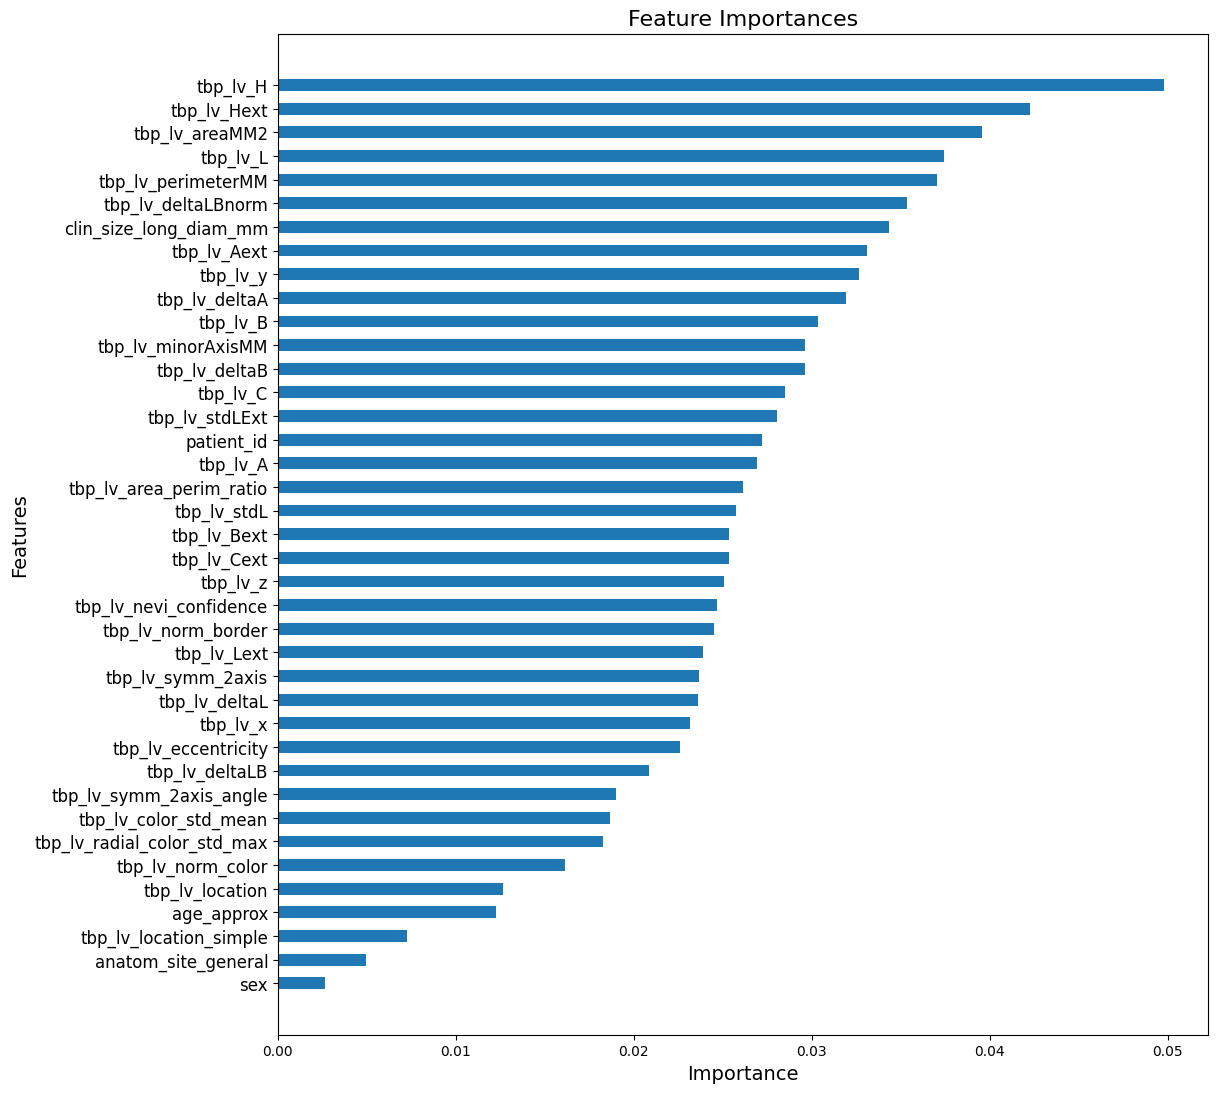

In [14]:
import matplotlib.pyplot as plt
 
importance = rf.feature_importances_
df_imp = pd.DataFrame({'feature': X_train.columns, 'importance': importance}).sort_values('importance', ascending=True)
fig, ax = plt.subplots(figsize=(12, 13))
ax.barh(df_imp['feature'], df_imp['importance'], height=0.5)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importances', fontsize=16)
ax.tick_params(axis='y', labelsize=12)
plt.show()


Plotted and interpreted feature importances from Random Forest. Identified lesion size, height, and perimeter as top predictors for skin cancer classification.

Generated heatmap to visualize feature correlations in the training dataset. Helps in identifying multicollinearity and strongly related features.

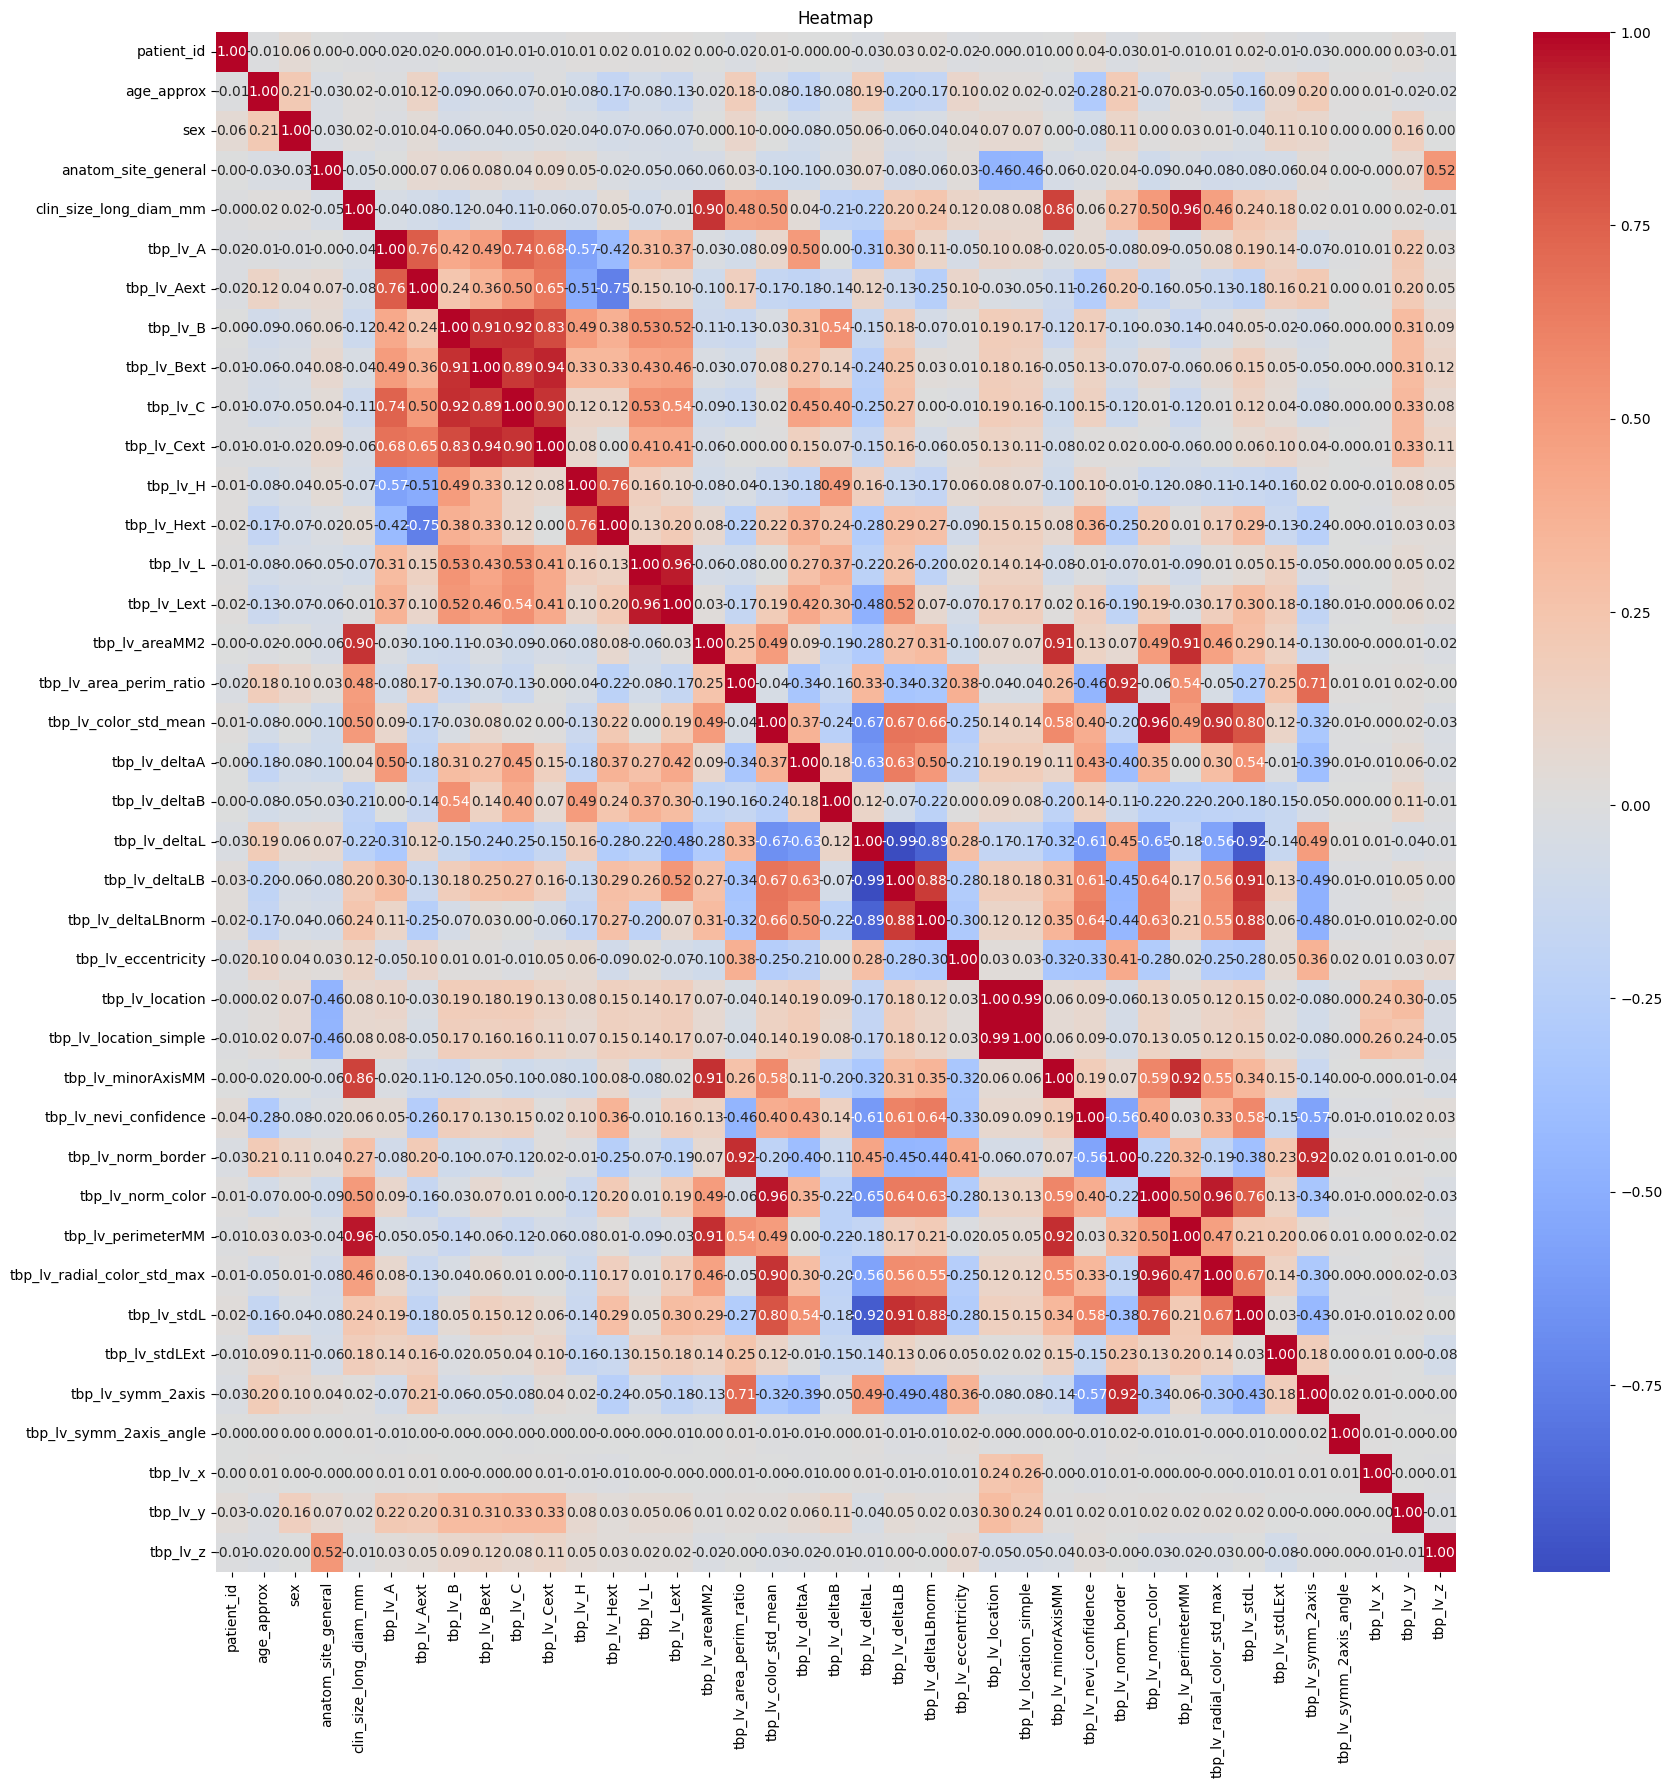

In [15]:
import seaborn as sns
numeric_columns = X_train
plt.figure(figsize=(20, 20))
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', annot_kws={'size': 10},cmap='coolwarm')
plt.title('Heatmap')
plt.show()

But many of them are corellated 

Plotted violin charts to compare categorical feature distributions against cancer targets. Helps in visually detecting class-wise spread and patterns in variables like sex, age, and lesion location.

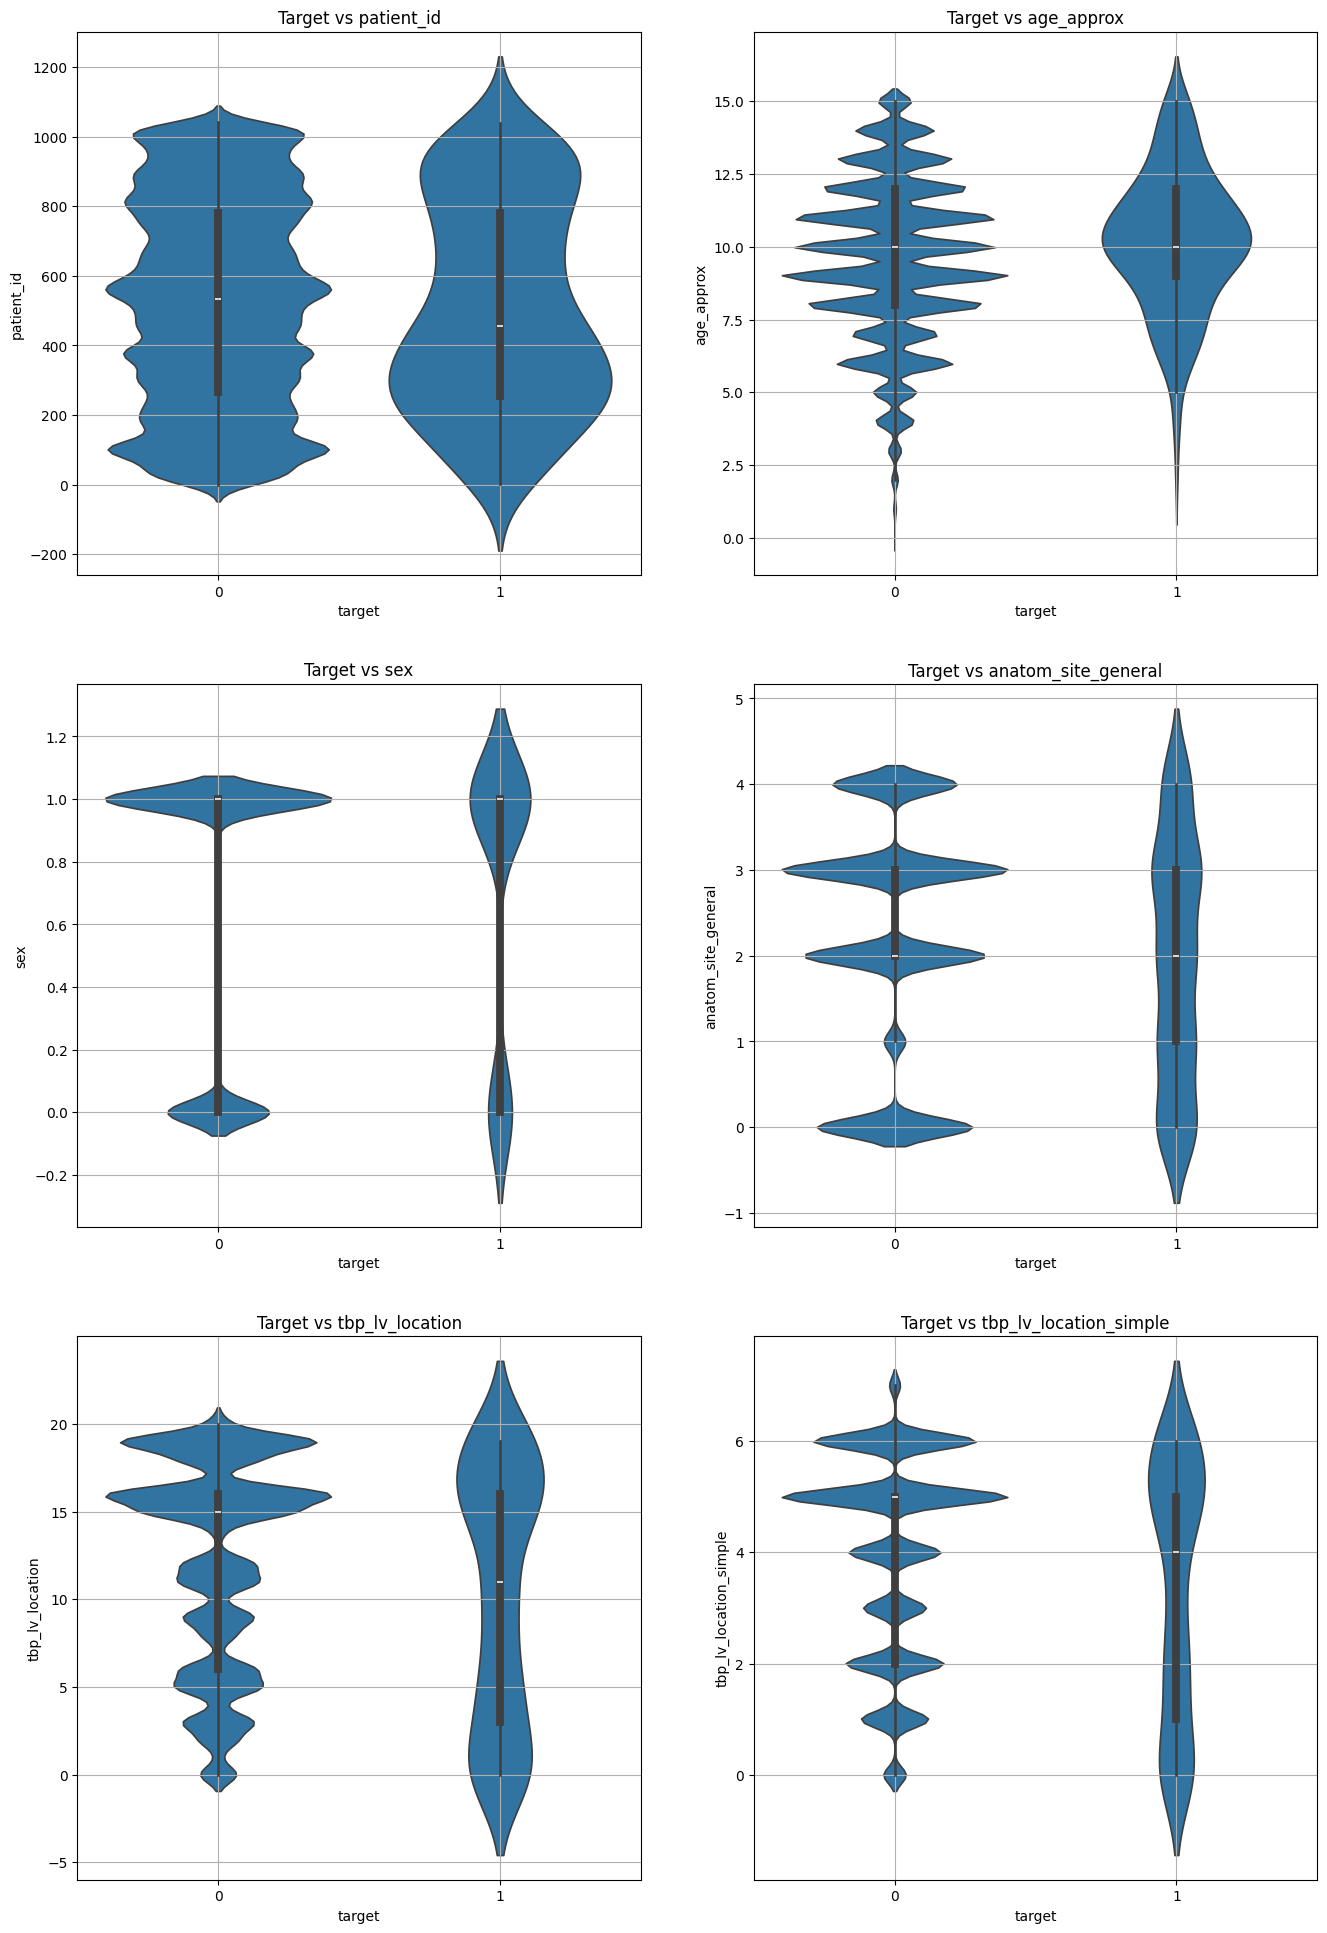

In [16]:
# X_train y_train
df_train = pd.concat([X_train, y_train], axis=1)
cat_df=['patient_id','age_approx','sex','anatom_site_general','tbp_lv_location','tbp_lv_location_simple']
features=cat_df


fig, axes = plt.subplots(nrows=len(features) // 2 + len(features) % 2, ncols=2, figsize=(16, len(cat_df) * 4))


for i, f in enumerate(features):
    row = i // 2
    col = i % 2
    sns.violinplot(data=df_train, x='target', y=f, ax=axes[row, col])
    axes[row, col].set_title('Target vs ' + f)
    axes[row, col].grid()